This code is to try to do the CrankNicolson in 1D

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.linalg as la

class GPE1D:
    """A class that solves  [- d^2(u)/(dt)^2 + w*x^2 + N.u^2 - j. du/dt] = 0
    Spectral stepping method for solving PDEs"""
    def __init__(self, Nx, N, L,w):
        """Initialize the spatial and spectral grids"""
        self.Nx = Nx
        self.N = N
        self.L = L
        self.w = w
        self.x, self.dx = np.linspace(0, self.L, self.Nx, retstep=True)
        self.k = 2*np.pi*np.fft.fftfreq(self.Nx, d=self.dx)        
        self.u = np.zeros(Nx,dtype = complex)
        
    def initialize(self, func):
        """Set the initial condition"""
        self.u = func(self.x)
        
    def FourierStep(self, dt):
        """Make a step dt forward in time for i*du/dt = -d^2(u)/dt^2"""
        uk = np.fft.fft(self.u)
        uk = np.exp(-self.k**2 * dt*1j)*uk
        self.u = np.fft.ifft(uk)
        
    def H1Step(self,dt):
        """Make a step dt forward in time for i*du/dt = w*x^2/4 + N.u^2"""
        self.u = self.u * np.exp(-1j*(self.w*self.x**2/4 + self.N * self.u**2) * dt)
        
    def step(self,dt):
        """Make a step dt forward in time for i*du/dt = H.u"""
        self.FourierStep(dt)
        self.H1Step(dt)


In [6]:
def advance(GPE, T, Nt):
    dt = T / Nt
    for _ in range(Nt):
        GPE.step(dt)

In [7]:
class Gaussian:
    """Gaussian function"""
    def __init__(self, width, amplitude, x0):
        """Create Gaussian with the given width and amplitude, centered at x = x0"""
        self.width = width
        self.amp = amplitude
        self.x0 = x0
        
    def __call__(self, x):
        """Evaluate the function for the values of x"""
        return self.amp * np.exp(-(x-self.x0)**2 / self.width**2)
# create a Gaussian object
gauss = Gaussian(8.87, 0.3, 250)

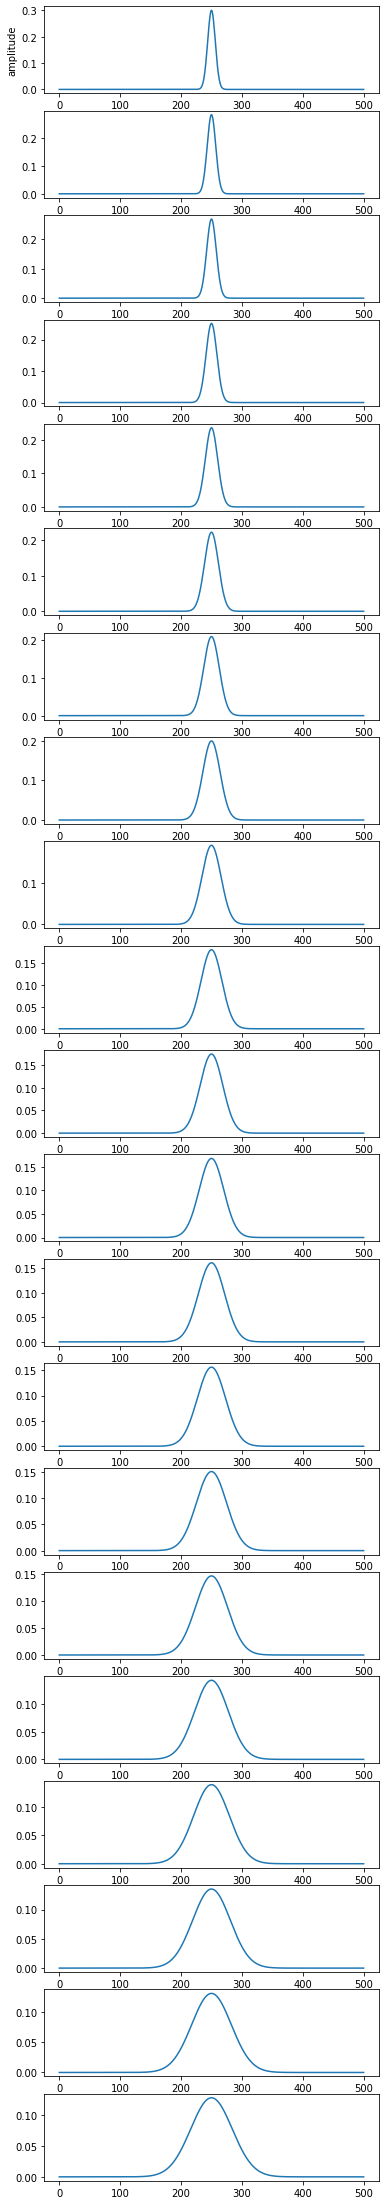

In [9]:
#Test for w = 0, N = 0
w = 0           #Valeur de w dans l'equation
N = 0         #Valeur de N dans l'equation
Nx = 1000      #Nombre de pas de x
L = 500        #x_max
Nt = 4000      #Nombre de pas de temps
T = 5         #Temps total
NT = 20        #Nombre de pas de T
GPE = GPE1D(Nx,N,L,w)
GPE.initialize(gauss)
advance(GPE,T,Nt)
x = GPE.x

fig, ax = plt.subplots(NT+1,figsize=(6, 2*NT))
ax[0].plot(x, gauss(x), label='u(t=0)')
ax[0].set_xlabel('x [cm]')
ax[0].set_ylabel('amplitude')
for i in range(NT):
    advance(GPE,T,Nt)
    ax[i+1].plot(x, abs(GPE.u))